# Explore HLS composite metadata

In [2]:
# Must install plotnine here to get current version so that plots works - otherwise, errors you cant debug...
!pip install plotnine

  Using cached mizani-0.9.3-py3-none-any.whl.metadata (4.6 kB)
Using cached mizani-0.9.3-py3-none-any.whl (73 kB)
  Attempting uninstall: mizani
    Found existing installation: mizani 0.10.0
    Uninstalling mizani-0.10.0:
      Successfully uninstalled mizani-0.10.0


In [3]:
import sys
import os

import geopandas as gpd
import pandas as pd

#sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils

import datetime


import json
import glob

import s3fs
import numpy as np
s3 = s3fs.S3FileSystem(anon=False)

NASA MAAP


In [4]:
from mosaiclib import *

In [5]:
from plotnine import *

In [6]:
boreal_tiles = gpd.read_file(boreal_tile_index_path.split('v004')[0] + 'v004_model_ready.gpkg')

## Build a multi-year dataframe of the metadata for the HLS composites across all years

In [7]:
HLS_MOSAIC_JSON_FN_DICT

{'c2020oldv1': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/spring2022/HLS_tindex_master_mosaic.json',
 'c2020oldv2': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json',
 'c2020v2022nmt': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json',
 'c2020v2022pmm': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json',
 'c2020v2022datelines': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_L30_c2020/HLS_tindex_master_mosaic.json',
 'c2020v2022updated': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master_mosaic_updated.json',
 'c2020v2022updated_bad': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json',
 '2015': 's3://maap-ops-workspa

### HLS composite metadata shows various run types and counts for any yearly composite

In [8]:
YEAR_LIST = list(reversed(['2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']))

#### Tile-level metadata with the params for how multi-speccomposites were built is useful

Producing cloud-free composites for a short growing season is a challenge.  

In [9]:
import importlib
importlib.reload(ExtractUtils)

NASA MAAP


<module 'ExtractUtils' from '/projects/code/icesat2_boreal/lib/ExtractUtils.py'>

In [11]:
tindex_completed_list = []
hls_params_df_list = []
for YEAR in YEAR_LIST:
    
    hls_params_df = pd.read_csv(HLS_MOSAIC_JSON_FN_DICT[YEAR].replace('tindex_master_mosaic.json', 'input_params.csv'))
    
    hls_params_df['temporal_window'] = (pd.to_datetime(hls_params_df.end_month_day, format='%m-%d') - pd.to_datetime(hls_params_df.start_month_day, format='%m-%d'))/ np.timedelta64(1, 'D').astype(int)
    hls_params_df_list.append( hls_params_df)  
    
    tindex_completed = boreal_tiles.merge(hls_params_df[['tile_num','run_type','num_scenes']], how='left', left_on='tile_num', right_on='tile_num')
    tindex_completed.groupby(['run_type']).size()
    tindex_completed['year'] = YEAR
    tindex_completed['run_type_'] = tindex_completed['run_type'].str.split("_20", expand=True)[0]
    tindex_completed_list.append(tindex_completed)
    
    MISSING_TILES = set(boreal_tiles.tile_num.to_list()) - set(hls_params_df.tile_num.to_list())
    print(f"Year {YEAR}: {len(MISSING_TILES)} missing out of {boreal_tiles.shape[0]}")
    
    if False:
        ExtractUtils.plot_gdf_on_world(tindex_completed, TITLE=f"{YEAR} composite run type")
        ExtractUtils.plot_gdf_on_world(tindex_completed, MAP_COL="num_scenes", TITLE=f"{YEAR} composite # of scenes per tile")



Year 2024: 4941 missing out of 4956
Year 2023: 0 missing out of 4956
Year 2022: 0 missing out of 4956
Year 2021: 0 missing out of 4956
Year 2020: 0 missing out of 4956
Year 2019: 0 missing out of 4956
Year 2018: 1 missing out of 4956
Year 2017: 2 missing out of 4956
Year 2016: 1 missing out of 4956
Year 2015: 17 missing out of 4956


In [83]:
import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/pangeo/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/envs/pangeo/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


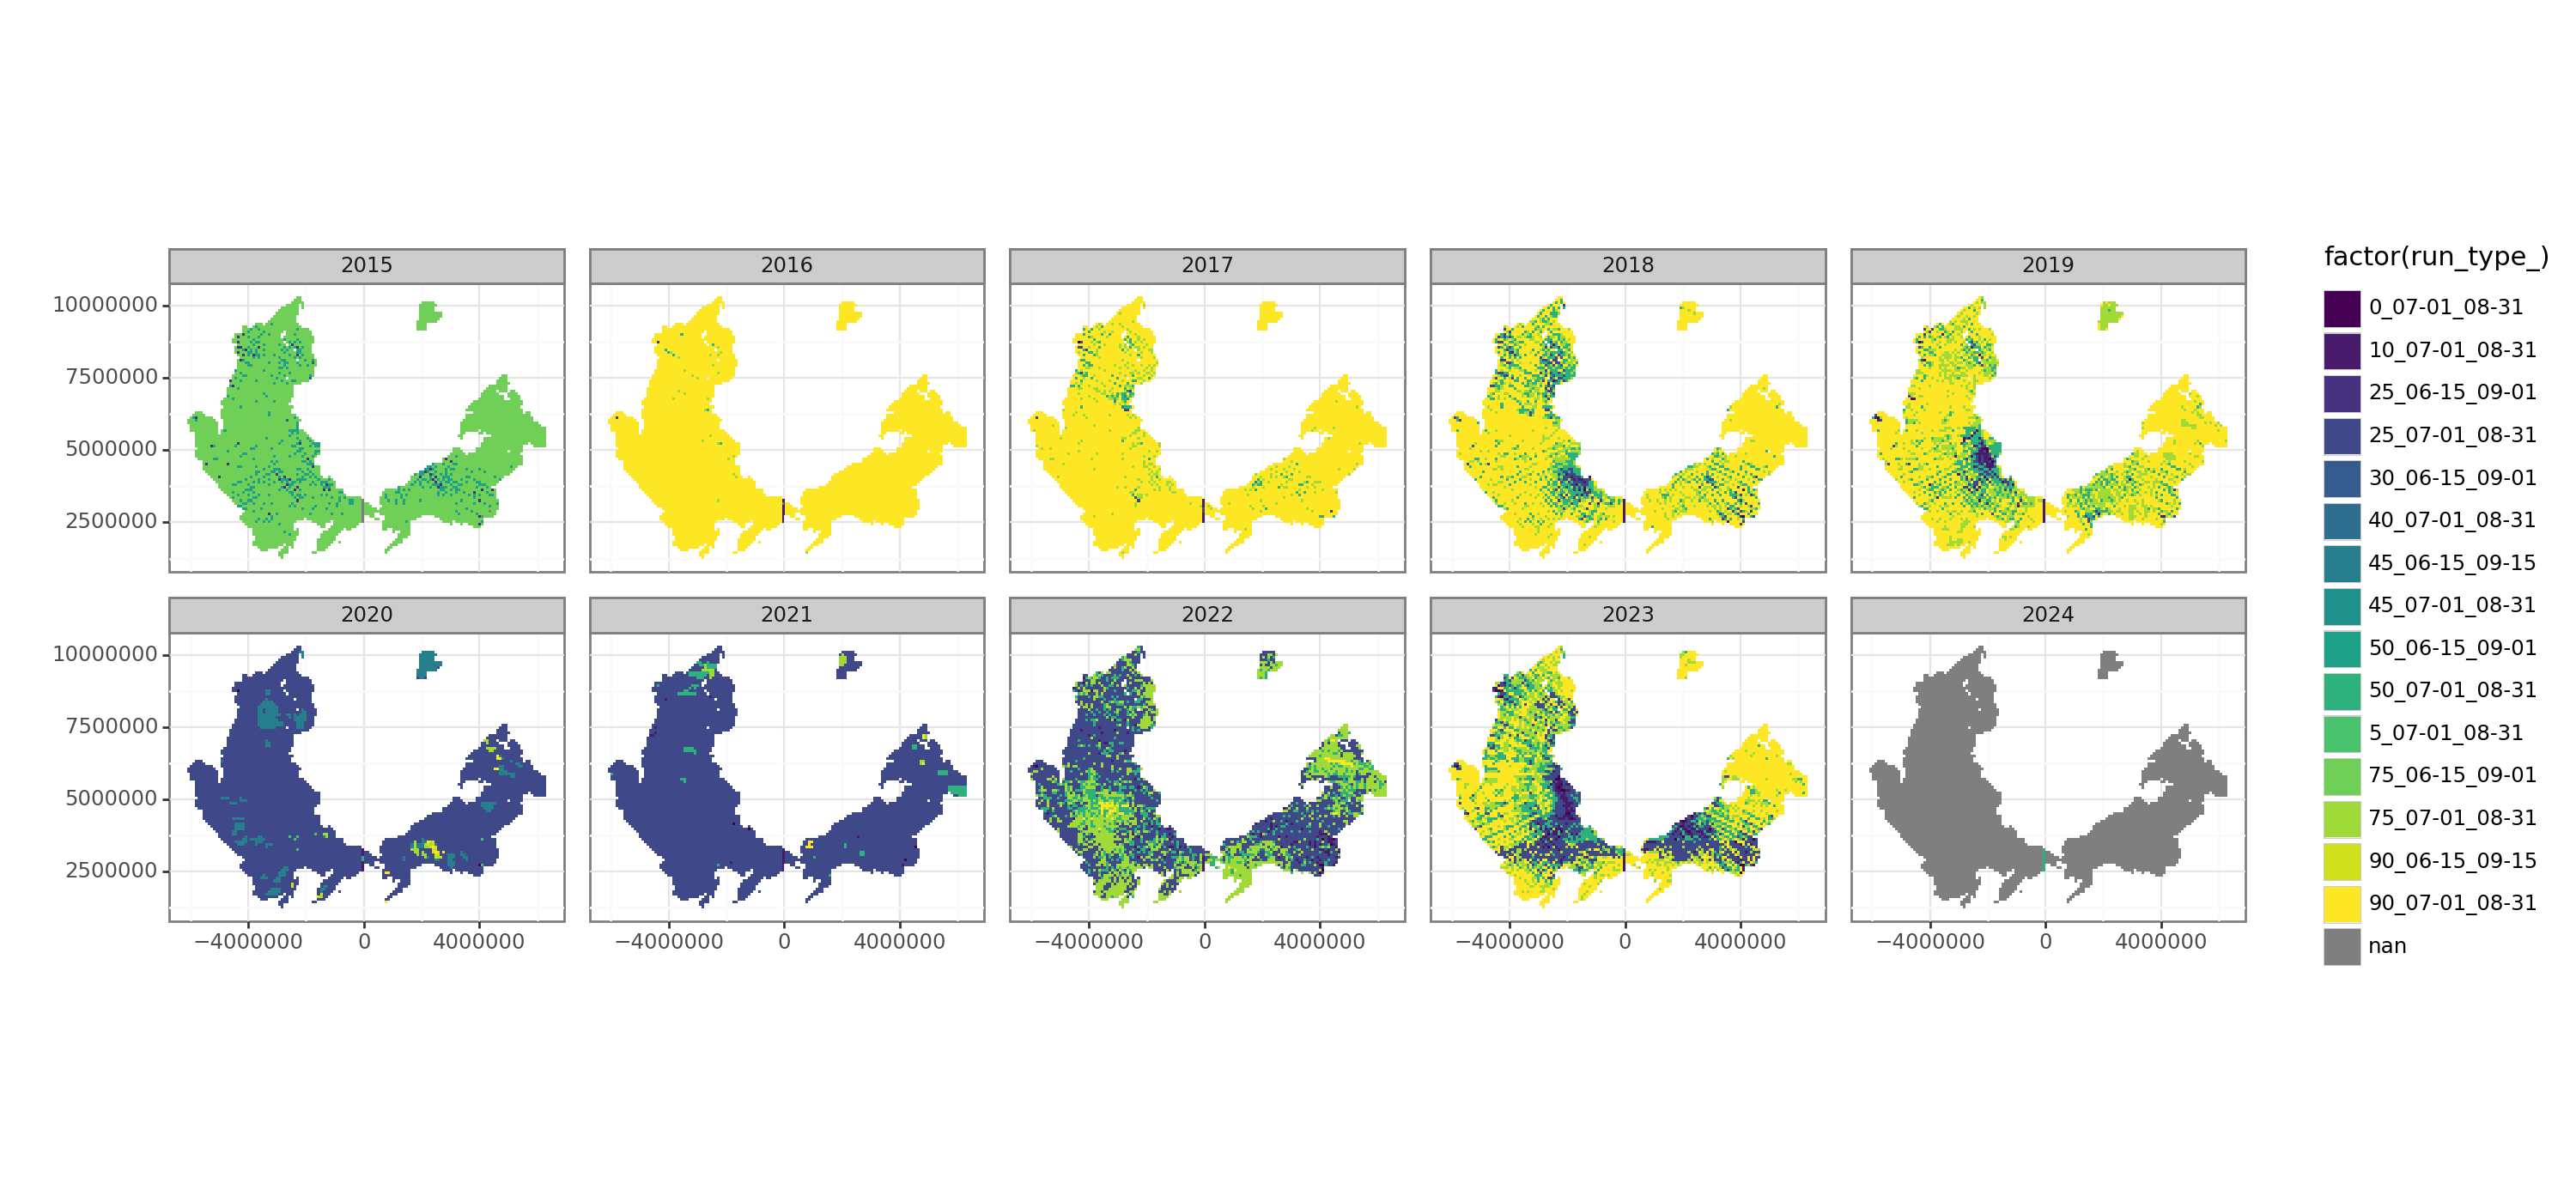

In [12]:
p = (
    ggplot(data = pd.concat(tindex_completed_list))
    + geom_map(aes(fill="factor(run_type_)"),  color='none')
    #+ scale_fill_cmap_d(cmap_name ='inferno_r', name='% cloud cover\n[max, HLS scene]')
    + scale_fill_cmap_d(name ='viridis')
    #+ facet_grid('~end')
    + theme_bw()
    + theme(figure_size=(15, 7))
    #+ labs(title=f'{YEAR} HLS Composite: count of scenes per 90 km2 tile', x='# HLS scenes', y='Count of 90 km2 tiles', fill='% cloud cover [max]')
    + facet_wrap('~year', ncol=5)
    + coord_equal()
)
print(p)

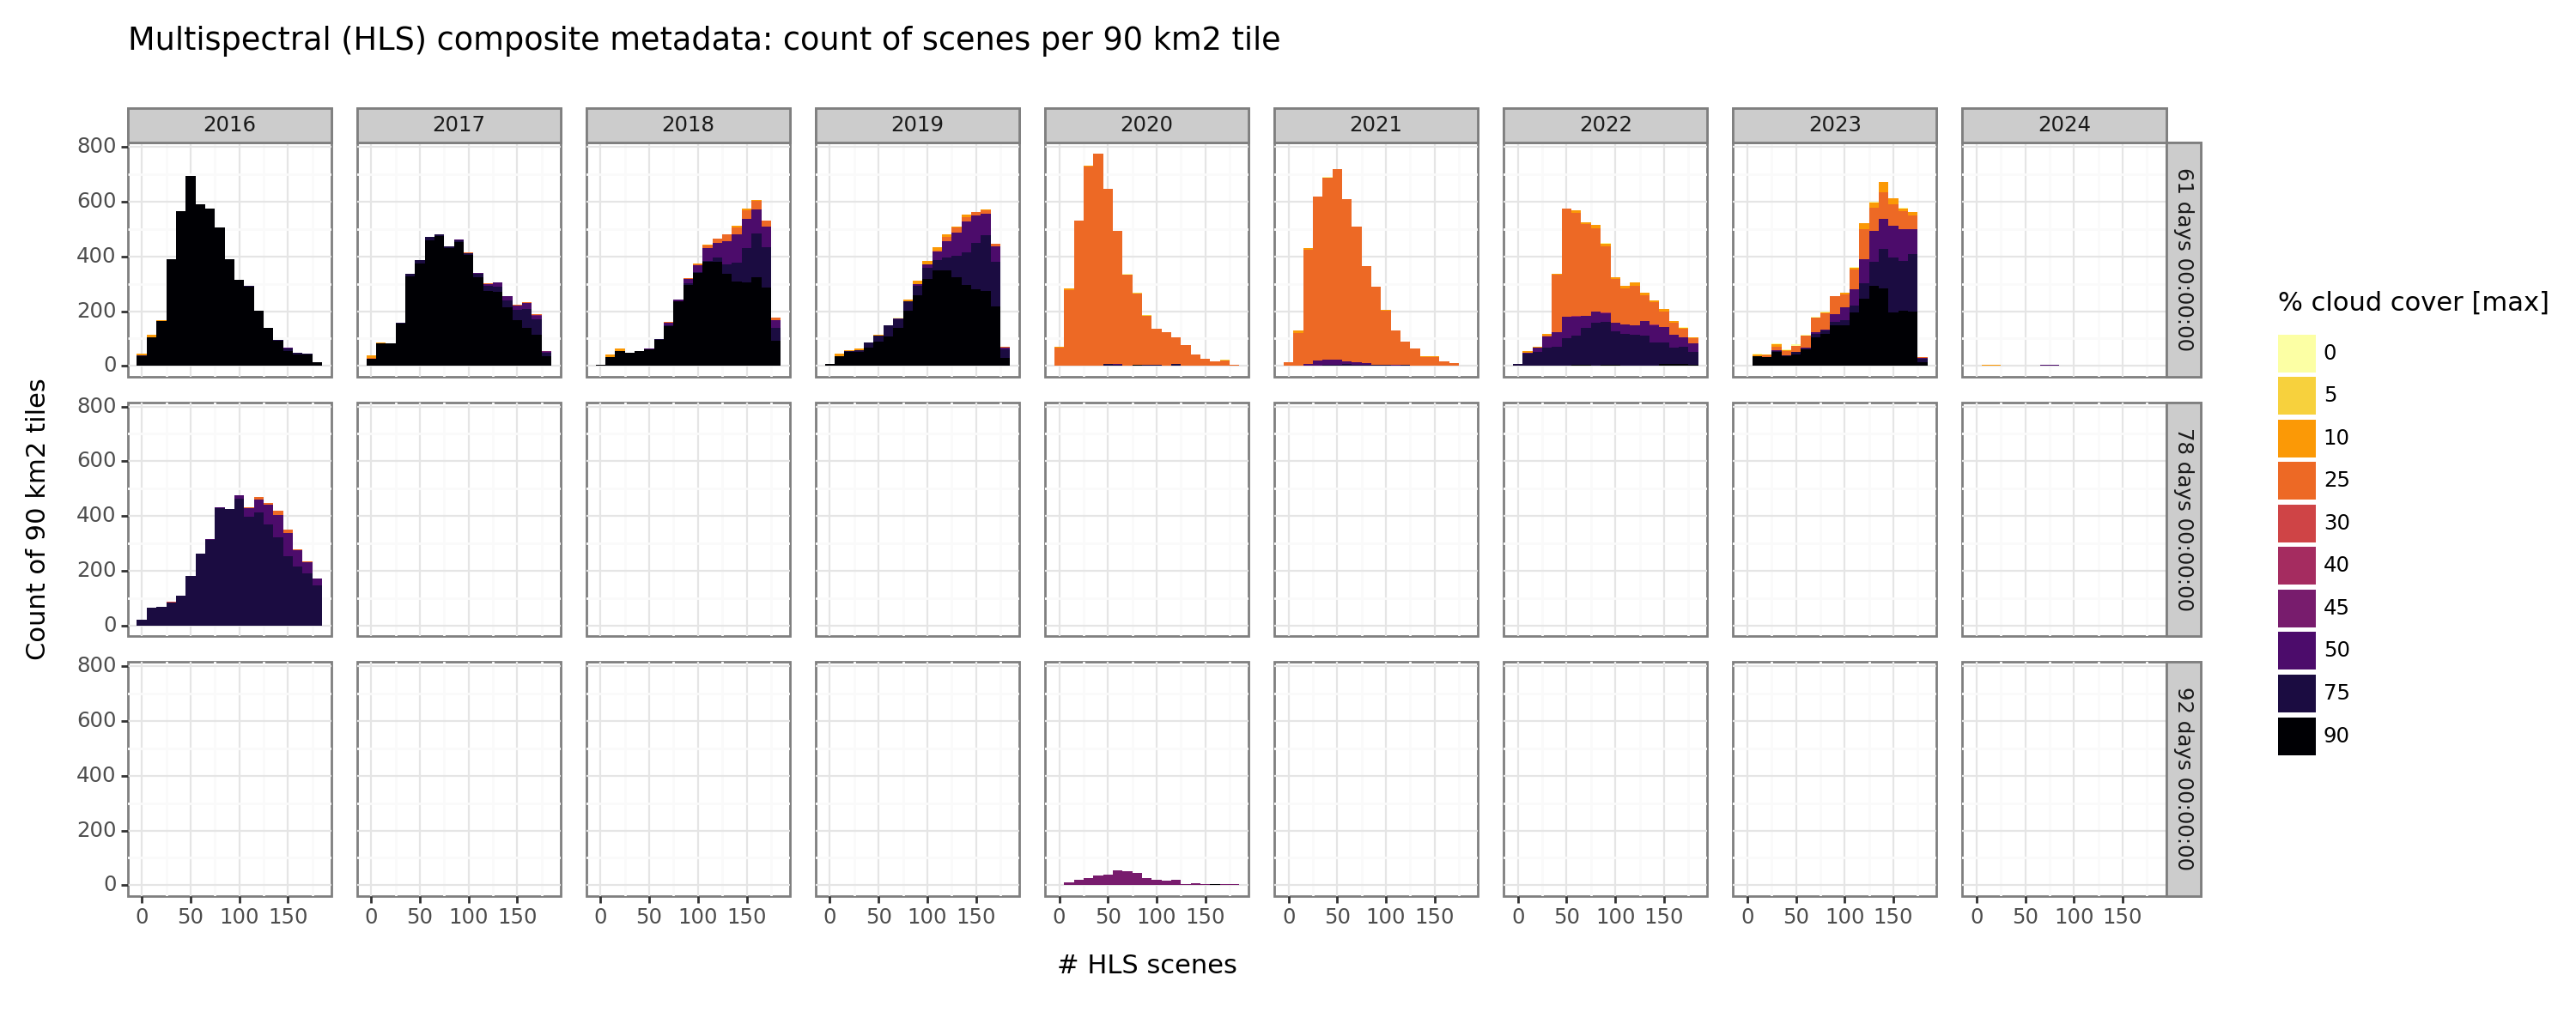

In [84]:
p = (
    ggplot(data = pd.concat(hls_params_df_list))
    + geom_histogram(aes(x='num_scenes', fill="factor(max_cloud)"), position='stack', binwidth=10)
    #+ scale_fill_cmap_d(cmap_name ='inferno_r', name='% cloud cover\n[max, HLS scene]')
    + scale_fill_cmap_d(name ='inferno_r')
    #+ facet_grid('~end')
    + theme_bw()
    + theme(figure_size=(15, 6))
    + labs(title='Multispectral (HLS) composite metadata: count of scenes per 90 km2 tile', x='# HLS scenes', y='Count of 90 km2 tiles', fill='% cloud cover [max]')
    + facet_grid('temporal_window~end_year')
)
print(p)

In [27]:
def wrapper_year_on_tindex(HLS_TINDEX_FN_DICT, YEAR):
    tindex_df = pd.read_csv(HLS_TINDEX_FN_DICT[YEAR])
    tindex_df['year'] = int(YEAR)
    return tindex_df
    
    
tindex_hls_df = pd.concat([wrapper_year_on_tindex(HLS_TINDEX_FN_DICT, YEAR) for YEAR in YEAR_LIST])

In [29]:
hls_params_df_updated = tindex_hls_df.merge(hls_params_df, how='left', left_on=['tile_num', 'year'], right_on=['tile_num', 'start_year'])

In [62]:
custom_axis = theme(axis_text_x = element_text(color="black", size=6, angle=0, hjust=.3),
                    axis_text_y = element_text(color="black", size=6), 
                    plot_title = element_text(size = 25, face = "bold"), 
                    axis_title = element_text(size = 10)  
                    ) 

In [54]:
hls_params_df_updated['creation_datetime'] = hls_params_df_updated['creation time'].astype('datetime64[ns]')

In [139]:
import datetime

/opt/conda/envs/pangeo/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/envs/pangeo/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 5254 rows containing missing values.
/opt/conda/envs/pangeo/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


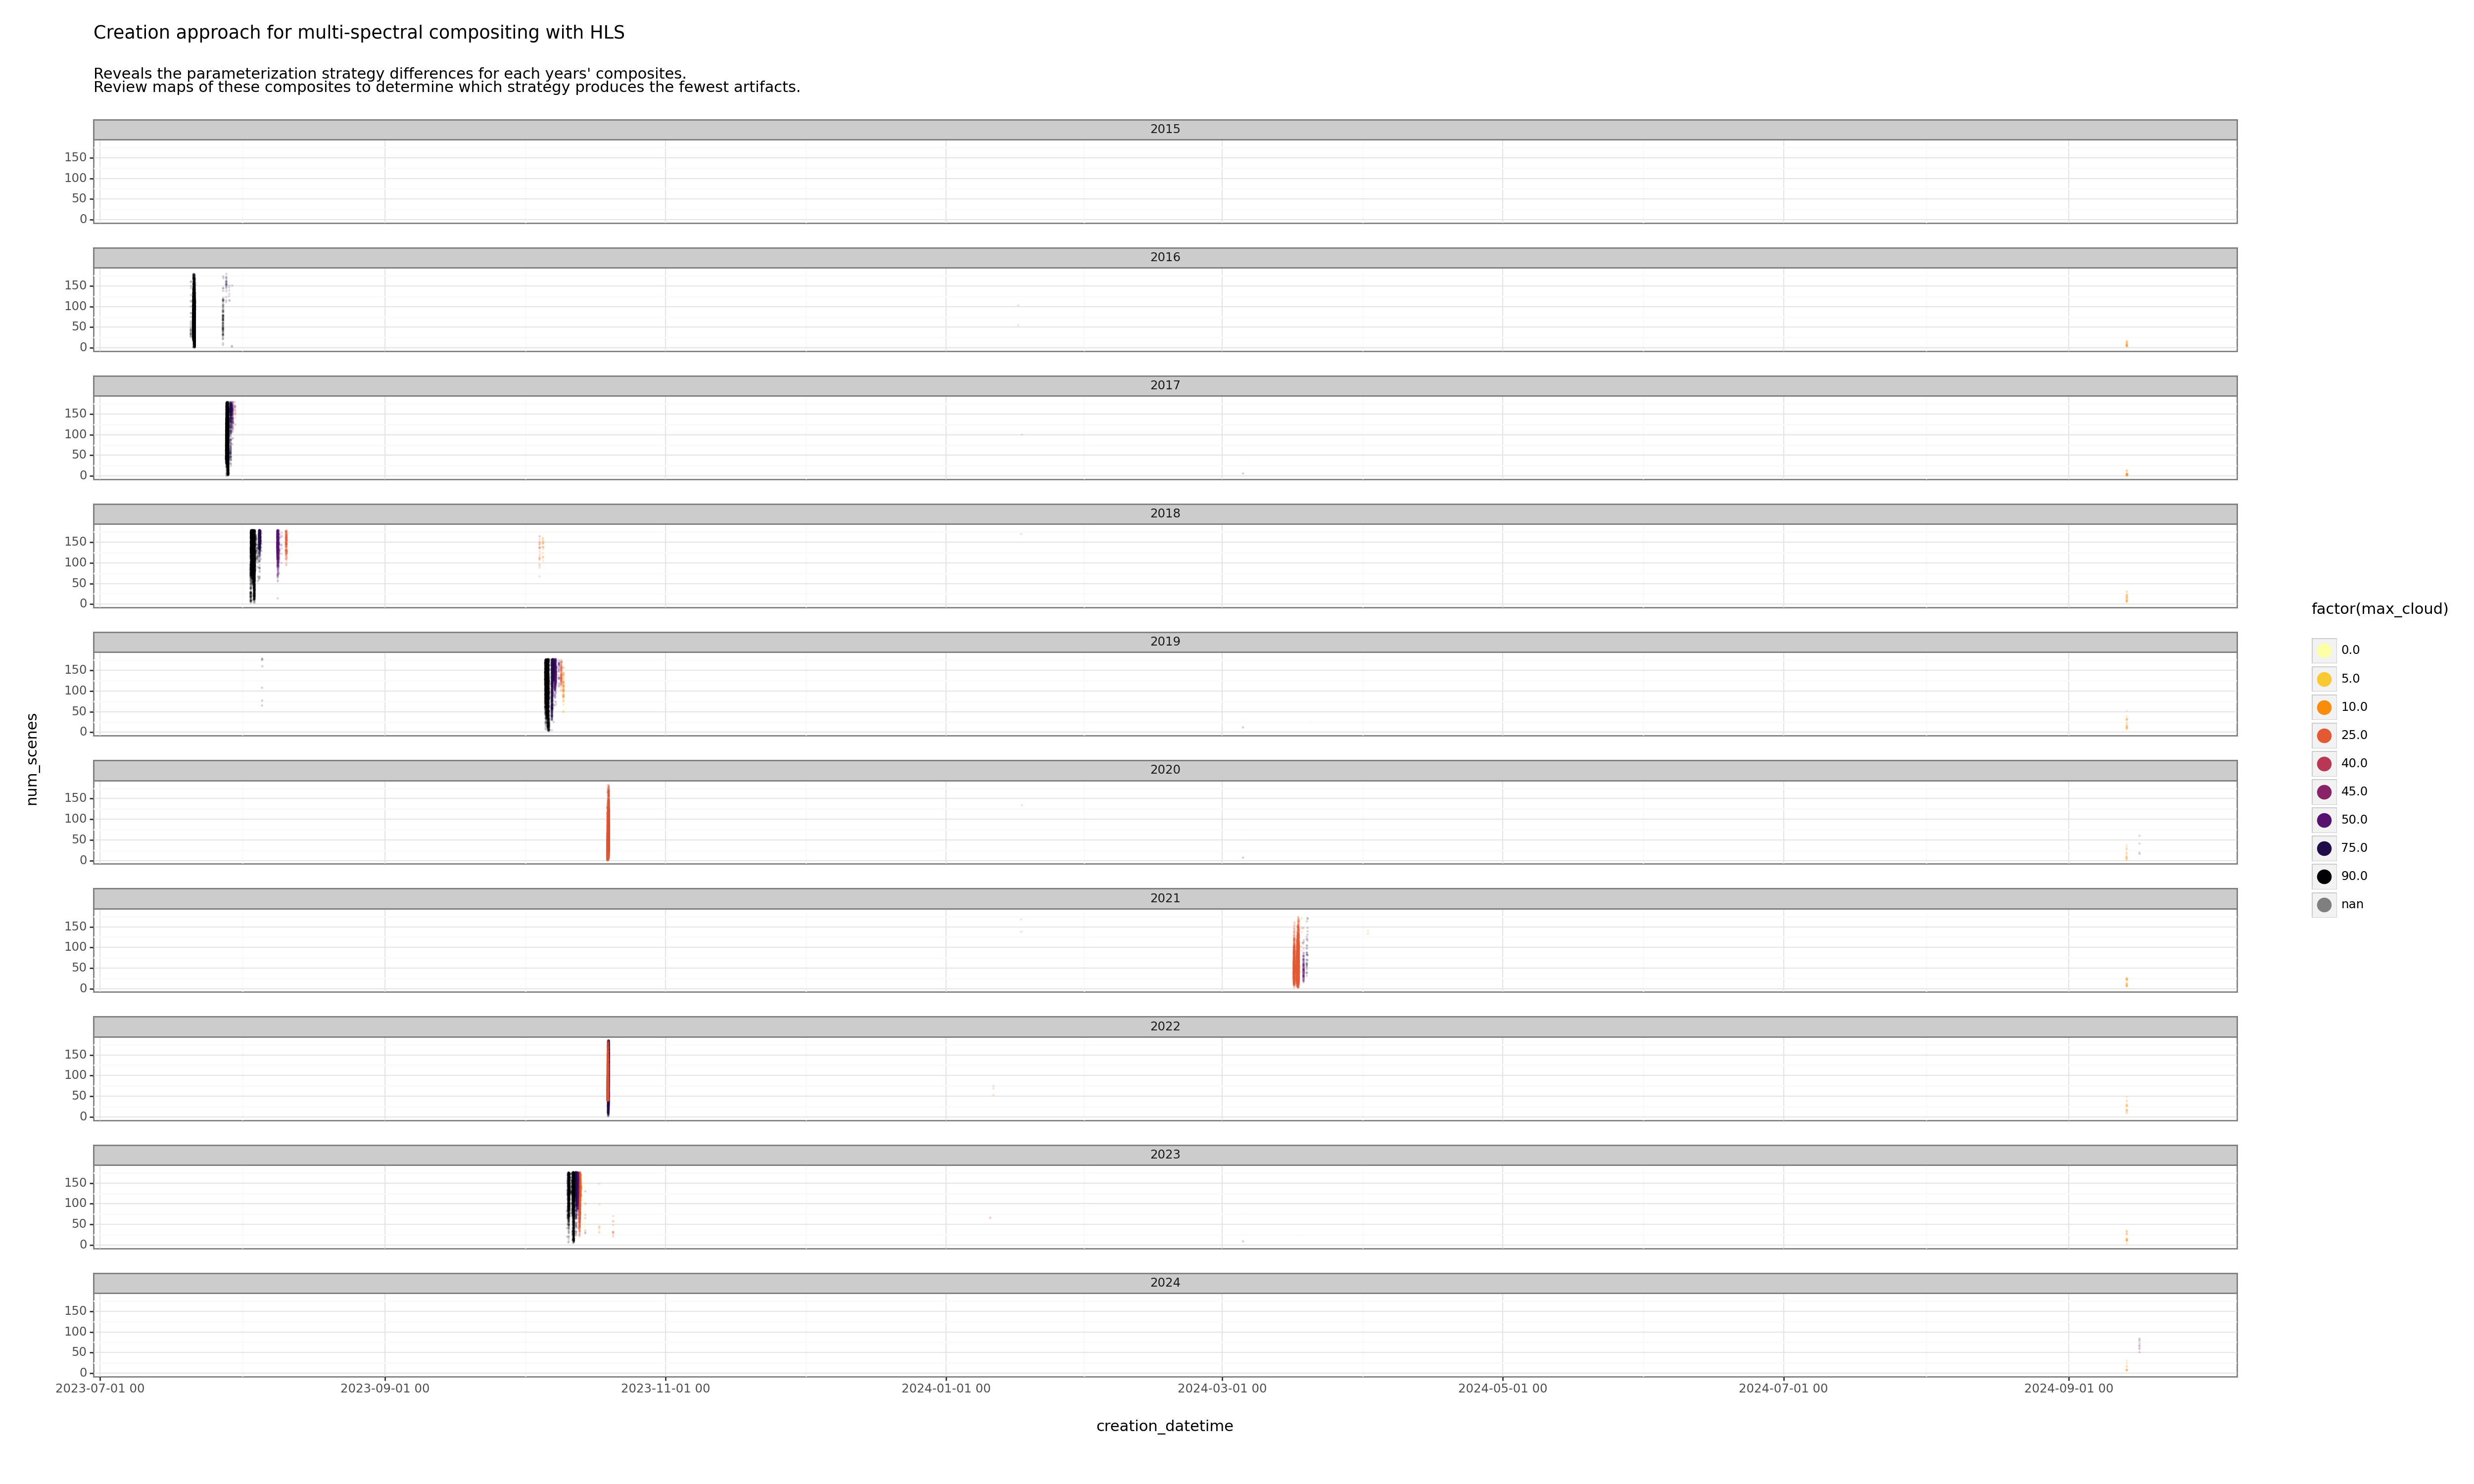

<Figure Size: (2500 x 1500)>

In [140]:
(
 ggplot(hls_params_df_updated, aes(x='creation_datetime', y='num_scenes', color="factor(max_cloud)", group='year')) 
    + geom_point(size=0.1, alpha=.1)
    + scale_color_cmap_d(name ='inferno_r')
    + scale_x_datetime(labels = date_format("%Y-%m-%d %H"))
    + theme_bw()
    + theme(figure_size=(25, 15))
    + facet_wrap('~year', ncol=1)
    + guides(color = guide_legend(override_aes = {'size':5, 'alpha':1} ) )
    + labs(title='Creation approach for multi-spectral compositing with HLS',subtitle="Reveals the parameterization strategy differences for each years' composites.\nReview maps of these composites to determine which strategy produces the fewest artifacts.")
    #+ coord_cartesian(xlim=[datetime.datetime(2023,6,1), datetime.datetime(2024,3,1)])
    #+ custom_axis
)

### For most of the tiles, a 25% cc threshold across a temporal window of 61 days (July-Aug). For most of the remaining tiles compositing artifacts forced us to broaden the temporal window and increase the cloudcover threshold to produce continuous composites. 

In [86]:
#MAINDIR_STR = f'/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/HLS_H30_{YEAR}/**'
MAINDIR_STR_S3 = f's3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/HLS_H30_{YEAR}/**'

In [88]:
YEAR

'2015'

In [87]:
#hls_json_meta_list = [glob.glob(os.path.join(os.path.dirname(hls_tindex.local_path.to_list()[i]), f'master_{hls_tindex.tile_num[i]}_*_HLS.json')) for i in range(len(hls_tindex))]
#hls_json_meta_list = glob.glob(f"{MAINDIR_STR}/master_*_HLS.json", recursive=True)
hls_json_meta_list = [f.replace('maap-ops-workspace/montesano','/projects/my-private-bucket') for f in s3.glob(f"{MAINDIR_STR_S3}/master_*_HLS.json")]
hls_json_meta_list[0]

IndexError: list index out of range

In [31]:
%%time

gdf_list = []
df_list = []
df_smry_list = []
fn_not_found_list=[]

def season_classifier(row):
    if '01' in row["start_month"]:
        return "wet"
    else:
        return "dry"

for fn in hls_json_meta_list:
    
    # Cant make gdf and df during one single open...
    try:
        with open(fn) as f:

            # Build geodataframes
            gdf = gpd.GeoDataFrame.from_features(json.load(f), crs=4326)
            gdf_list.append(gdf)

        with open(fn) as f:

            # Build dataframe of attributes
            df = pd.json_normalize(json.load(f), record_path=['features'])
            #df['datetime'] = pd.to_datetime(df.id.str.split('.', expand=True)[3], format='%Y%jT%H%M%S')
            #df['doy'] = df['datetime'].dt.dayofyear
            df['filename'] = os.path.basename(fn)
            df['start'] = os.path.basename(fn).split('_')[2]
            df['start_month'] = os.path.basename(fn).split('_')[2].split('-')[1]
            df['year'] = os.path.basename(fn).split('_')[2].split('-')[0]
            df['season'] = 'none'
            if False:
                df['season'] = df.apply(season_classifier, axis=1)
            df['end'] = os.path.basename(fn).split('_')[3]
            df_smry = df.groupby(['filename','year','season']).size().reset_index(name='counts')
            df_list.append(df)
            df_smry_list.append(df_smry)
    except:
        print(f'File not found: {fn}')
        fn_not_found_list.append(fn)

df = pd.concat(df_list)
df_smry = pd.concat(df_smry_list)
df_smry.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5740 entries, 0 to 0
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  5740 non-null   object
 1   year      5740 non-null   object
 2   season    5740 non-null   object
 3   counts    5740 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 224.2+ KB
CPU times: user 2min 57s, sys: 6.43 s, total: 3min 4s
Wall time: 9min 44s


### Geodataframe show all the pieces of HLS scenes used for all tiles
duplicate HLS scenes indicate where scenes were used for multiple tiles

In [48]:
%%time
hls_scene_part_gdf = pd.concat([pd.concat(gdf_list), pd.concat(df_list)], axis=1)
hls_scene_part_gdf.drop( [c for c in hls_scene_part_gdf.columns for s in ['assets','links','properties'] if s in c], axis=1, inplace=True)

CPU times: user 10.2 s, sys: 388 ms, total: 10.6 s
Wall time: 10.6 s


In [50]:
hls_scene_part_gdf.shape

(296852, 19)

In [49]:
hls_scene_part_gdf.groupby('id').agg({'id':['count']}).shape

(64330, 1)

In [51]:
hls_scene_gdf = hls_scene_part_gdf.dissolve(by='id')

In [153]:
hls_scene_gdf['datetime'] = pd.to_datetime(hls_scene_gdf['datetime'])
hls_scene_gdf['doy'] = pd.to_datetime(hls_scene_gdf['datetime']).dt.dayofyear

In [154]:
hls_scene_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 64330 entries, HLS.L30.T01VCK.2020208T232307.v2.0 to HLS.S30.T60WWV.2020209T000621.v2.0
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   geometry              64330 non-null  geometry           
 1   eo:cloud_cover        64330 non-null  int64              
 2   datetime              64330 non-null  datetime64[ns, UTC]
 3   start_datetime        64330 non-null  object             
 4   end_datetime          64330 non-null  object             
 5   type                  64330 non-null  object             
 6   stac_version          64330 non-null  object             
 7   stac_extensions       64330 non-null  object             
 8   collection            64330 non-null  object             
 9   bbox                  64330 non-null  object             
 10  geometry.type         64330 non-null  object             
 11  ge

<Axes: >

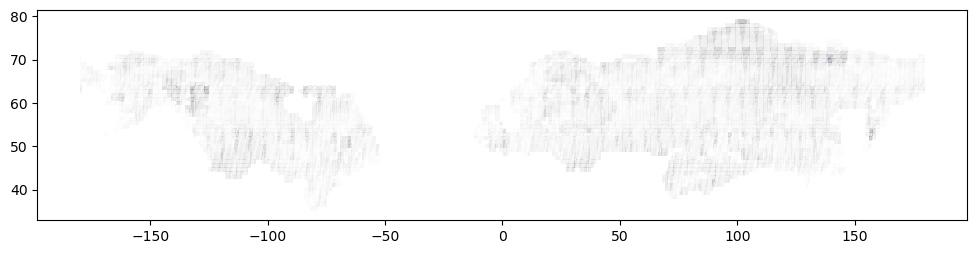

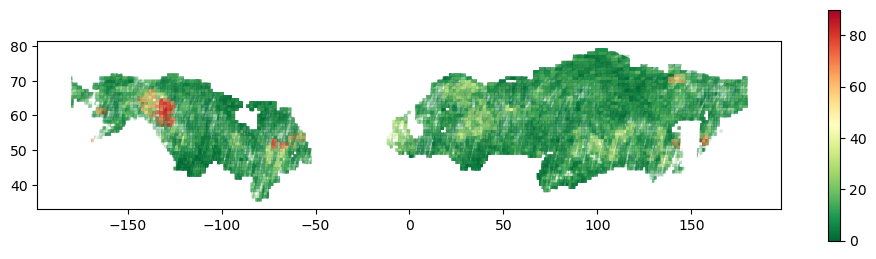

In [46]:
hls_scene_gdf.plot(alpha=0.005, legend=True, figsize=(12,3))
hls_scene_gdf.plot(column='eo:cloud_cover', alpha=0.25, cmap='RdYlGn_r', legend=True, figsize=(12,3))

In [16]:
# hls_json_meta_list = ['s3://'+f for f in s3.glob('s3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/mc*/**/master_*HLS.json')]
# hls_json_meta_list = ['s3://'+f for f in s3.glob('s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2023_v1/HLS_H30*/**/master_*HLS.json')]
# hls_json_meta_list[0]

In [6]:
import plotnine
from plotnine import *

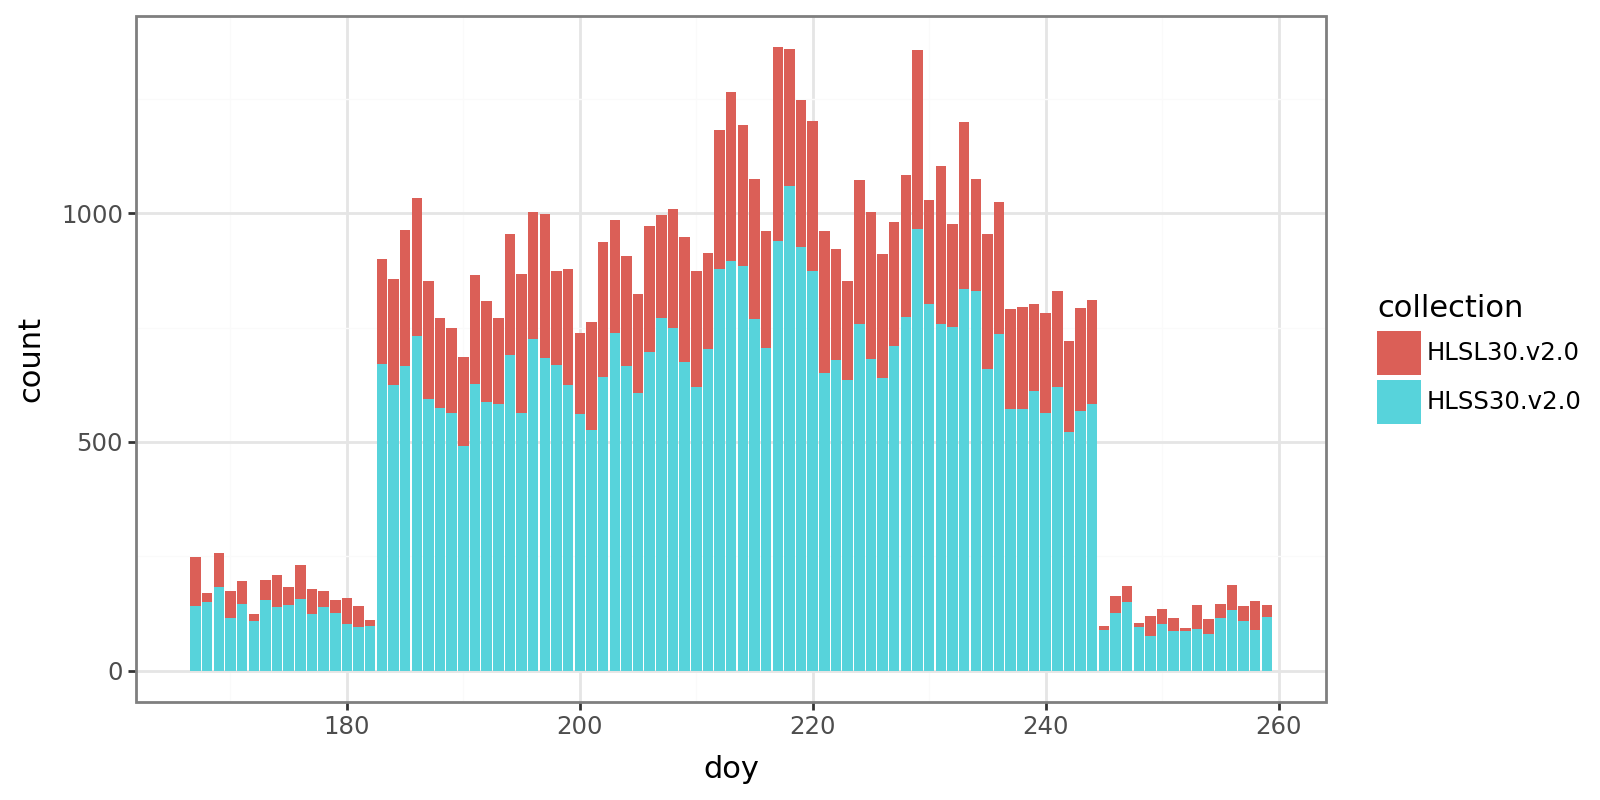

In [156]:
var = 'properties.eo:cloud_cover'
(
    ggplot(data = hls_scene_gdf)
    #+ geom_point(aes(x='start', y=var))
    + geom_bar(aes(x='doy', fill='collection'))
    #+ facet_grid('~end')
    + theme_bw()
    + theme(figure_size=(8, 4)) 
    )